In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Import generic libraries
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.io
import os, sys
import tqdm
from scipy.optimize import curve_fit
from pathlib import Path
import pickle

In [6]:
# Import local tools
sys.path.append(os.path.expanduser('~/Desktop/Analysis/kohl-lab-pynalysis/'))
from pynalysis import utils

In [7]:
# sys.path.append(os.path.expanduser('/home/zenke/projects/2017-kohl/tensortools/'))
# import tensortools as tt

In [8]:
# Import local OASIS installation
sys.path.append(os.path.expanduser('~/Desktop/Analysis/OASIS-master/'))
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
from oasis import oasisAR1, oasisAR2

/Users/mariangelapanniello/Desktop/Analysis/OASIS-master/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [9]:
import sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso

In [10]:
def datamatrix2tensor(data, event_times, toff_after, toff_before=0):
    """ Slices flat data matrix into trial based tensor.
    
    Expects data to be time x unit.
    
    Returns: A tuple of (list, tensor) in which the list contains the indices of valid trials (ie. the ones
    for which the time interval was valid) and the tensor contains the data in format trial x time x unit.
    """
    trials = []
    indices = [] 
    nb_frames = data.shape[0]
    for i,ev in enumerate(event_times):
        fr = int(ev)
        if fr<toff_before or fr>nb_frames-toff_after: continue
        s = data[fr-toff_before:fr+toff_after]
        trials.append(s)
        indices.append(i)
    return indices, np.array(trials)

In [11]:
def tensorbin(data, bin_size=10):
    """ Takes data tensor and bins it """
    nb_bins = data.shape[1]//bin_size
    #print(data.shape)
    binned = []
    for i in range(nb_bins):
        a = data[:,i*bin_size:(i+1)*bin_size,:]
        # print(a.shape)
        binned.append(np.sum(a,axis=1))
    return np.transpose(np.array(binned),axes=[1,0,2])
    
def bin_data(data, event_times, toff_after=60, toff_before=0, bin_size=10, axis=1):
    datatensor = datamatrix2tensor(data,event_times,toff_before=toff_before, toff_after=toff_after)
    #     return datatensor.mean(axis=axis)
    return tensorbin(datatensor, bin_size)

In [12]:
def split_dataset(dataset, split=0.8, shuffle=False):
    x,y = dataset
    n = len(x)
    s = int(split*n)
    idx = np.arange(len(x))
    if shuffle: np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    x_train = x[:s]
    x_valid = x[s:]
    y_train = y[:s]
    y_valid = y[s:]
    return (x_train, y_train),(x_valid, y_valid)

In [13]:
def fuse_dataset(data, labels):
    d = data.reshape((data.shape[0],-1))
    return d,labels

In [14]:
def get_acc(dataset):
    pred=svc.predict(dataset[0])
    acc=(pred==dataset[1]).mean()
    return acc

In [15]:
def get_acc_all_times(all_data, labels, units="all", kernel="linear"):
    """ Fits SVC over all times
    
    Args:
    all_data : Expects datatensor with trials x time x unit. 
    labels : The labels for training the classifier.
    units : A list of indices of units to include in the analysis or "all" for all (default "all").
    kernel : The kernel to use for the classifier.
    
    Returns classification accuracy scores for 5-fold CV of a linear classifer.
    """
    if units=="all":
        data_selection = all_data
    else:
        data_selection = all_data[:,:,units]
       
    dataset = fuse_dataset(data_selection,labels)
    clf = SVC(kernel=kernel, C=1)
    scores = cross_val_score(clf, dataset[0], dataset[1], cv=5)
    return scores

def scan_acc_time(all_data, labels, units="all", kernel="linear"):
    """ Fits SVC on each time slice from datatensor
    
    Args:
    all_data : Expects datatensor with trials x time x unit. 
    labels : The labels for training the classifier.
    units : A list of indices of units to include in the analysis or "all" for all (default "all").
    kernel : The kernel to use for the classifier.
    
    Returns classification accuracy scores for 5-fold CV of a linear classifer over time.
    """
    if units=="all":
        data_selection = all_data
    else:
        data_selection = all_data[:,:,units]
       
    results = []
    for t in range(data_selection.shape[1]):
        partial_data = data_selection[:,t,:]
        dataset = fuse_dataset(partial_data,labels)
        clf = SVC(kernel=kernel, C=1)
        scores = cross_val_score(clf, dataset[0], dataset[1], cv=5)
        results.append(scores)
    results = np.array(results)
    return results

# Main program

In [16]:
# Load external list of animals and experiments
experiments = pd.read_csv("~/Desktop/Analysis/kohl-lab-pynalysis/meta_data/MULTIBAR-animal-list.csv")

In [17]:
experiments

stringid  date_int area_name  area_num layers_desc  plane1_layer  \
0   CGCC8.5a  20180208    area01         1        L2-3             2   
1   CGCC8.5a  20180208    area02         2        L2-3             2   
2   CGCC8.5a  20180208    area03         3        L2-3             2   
3   CGCC8.5a  20180208    area04         4        L2-3             2   
4   CGCC8.5a  20180208    area05         5        L3-4             3   
5   CGCC8.5a  20180222    area01         1        L2-3             2   
6   CGCC8.5a  20180222    area02         2        L2-3             2   
7   CGCC8.5a  20180222    area03         3        L2-3             2   
8   CGCC8.5a  20180222    area04         4        L2-3             2   
9   AIGC1.1d  20180214    area01         1        L2-3             2   
10  AIGC1.1d  20180214    area02         2        L2-3             2   
11  AIGC1.1d  20180214    area03         3        L2-3             2   
12  AIGC2.2a  20180316    area01         1        L2-3             2   
13  AIGC2.2a  20180316    area02         2        L2-3             2   
14  AIGC2.2a  20180316    area04         4        L2-3             2   
15  AIGC2.2c  20180407    area01         1        L2-3             2   
16  AIGC2.2c  20180407    area02         2        L3-3             3   
17  AIGC2.2c  20180407    area03         3        L2-3             2   
18  AIGC2.3b  20180429    area01         1        L2-3             2   
19  AIGC2.3b  20180429    area02         2        L2-3             2   
20  AIGC2.3b  20180429    area03         3        L2-3             2   
21  AIGC2.3c  20180425    area01         1        L2-3             2   
22  AIGC2.3c  20180425    area02         2        L2-3             2   
23  AIGC2.3c  20180425    area03         3        L2-3             2   
24  AIGC2.3f  20180425    area01         1        L2-3             2   
25  AIGC2.3f  20180425    area02         2        L2-3             2   
26  AIGC2.3f  20180425    area03         3        L3-3             3   
27  AIGC2.3f  20180529    area01         1        L3-3             3   
28  AIGC2.3f  20180529    area02         2        L3-3             3   
29  AIGC2.3f  20180529    area03         3        L2-3             2   
30  AIGC2.3f  20180529    area04         4        L3-3             3   
31  CTBD2.1b  20180430    area01         1        L2-3             2   
32  CTBD2.1b  20180430    area02         2        L3-3             3   
33  CTBD2.1b  20180430    area03         3        L4-5             4   
34  CTBD2.1b  20180504    area01         1        L2-3             2   
35  CTBD2.1b  20180504    area02         2        L3-3             3   
36  CTBD2.1b  20180504    area03         3        L3-4             3   
37  CTBD2.1b  20180504    area04         4        L4-5             4   
38  VIP51.1a  20180321    area01         1        L2-3             2   
39  VIP51.1a  20180321    area02         2        L3-3             3   
40  VIP51.1a  20180321    area03         3        L3-4             3   

    plane2_layer stimulation_desc (#positions, #speeds)  nb_pos  nb_speed  \
0              3                         2 pos, 2 speed       2         2   
1              3                                    NaN       2         2   
2              3                                    NaN       2         2   
3              3                                    NaN       2         2   
4              4                                    NaN       2         2   
5              3                         4 pos, 1 speed       4         1   
6              3                                    NaN       4         1   
7              3                                    NaN       4         1   
8              3                                    NaN       4         1   
9              3                         2 pos, 2 speed       2         2   
10             3                         2 pos, 2 speed       2         2   
11             3                         3 pos, 2 speed

In [18]:
# utils.save_zipped_pickle(data_packs,"~/data/kohl/preprocessed/preprocessed_data.pkl.gz")

In [19]:
# Load preprocessed data from zipped pickle
data_packs = utils.load_zipped_pickle(os.path.expanduser("~/Desktop/Results/preprocessed/preprocessed_data.pkl.gz"))

# Extract accuracy with SVM

In [20]:
# Load datapacks run SVM and create pandas dataframe with the results
records = []
for area in data_packs:
    for plane in range(2):
        data = area['plane_data'][plane]['datatensor']
        labels = area["labels"]

        string_identifier = "%s/%s/plane%i"%(area["stringid"],area["expspecifier"],plane+1)
        print(string_identifier)
        
        nb_stimuli = len(np.unique(labels))
        chance_level = 1.0/nb_stimuli

        # perform min max scaling on a per neuron basis
        mi = area["plane_data"][plane]['traces'].min(0)
        ma = area["plane_data"][plane]['traces'].max(0)
        sd = area["plane_data"][plane]['traces'].std(0)
        # data = (data-mi)/(ma-mi+1e-7)
        data = data/(sd+1e-7)
        
        # check for nan in data
        if np.isnan(data.mean()):
            print("Warning dataset contains NAN. Skipping...")
            continue

        # Process time averaged trial data
        trialdata = data[:,15:45,:].mean(1)
        print("Total number of trials %i"%trialdata.shape[1])
        dataset = fuse_dataset(trialdata,labels)
        
        clf = SVC(kernel="linear", C=1)
        svm_scores = cross_val_score(clf, dataset[0], dataset[1], cv=5)
        
        acc2s_mean_score   = svm_scores.mean()
        acc2s_stdev_score  = svm_scores.std()
        print("Mean score %f"%acc2s_mean_score)
        
        # SVM on temporal trial data
        trialdata = data.reshape((data.shape[0],-1))
        # standardize
        tialdata = (trialdata-trialdata.min(0))/(trialdata.max(0)-trialdata.min(0)+1e-7)
        dataset = fuse_dataset(trialdata,labels)
        
        clf = SVC(kernel="linear", C=1)
        svm_scores = cross_val_score(clf, dataset[0], dataset[1], cv=5)
        
        acctemp_mean_score   = svm_scores.mean()
        acctemp_stdev_score  = svm_scores.std()
        print("Mean score %f"%acctemp_mean_score)
        
        # Running speed prediction
        alpha = 1e-3
        lasso = Lasso(alpha=alpha)

        # area['mean_trial_velocity'].std()
        trialdata = data[:,15:45,:].mean(1)
        dataset = (trialdata, area['mean_trial_velocity'])
        lasso_scores = []
        for i in range(20):
            trainset, testset = split_dataset(dataset, shuffle=True)
            lasso.fit(*trainset)
            y_pred_lasso = lasso.predict(testset[0])
            r2_score_lasso = r2_score(testset[1], y_pred_lasso)
            lasso_scores.append(r2_score_lasso)
        # scorer=sklearn.metrics.make_scorer(r2_score)
        # lasso_scores = cross_val_score(lasso, dataset[0], dataset[1], cv=5)
        # print(lasso)
        lasso_scores = np.array(lasso_scores)
        r2_score_lasso = lasso_scores.mean()
        print("r^2 on test data : %f" % r2_score_lasso)

        
        # import fields from experiments CSV file
        ex = experiments.loc[area["index"]]
        
        # combine results to record
        rec = dict( stringid=area["stringid"], 
                    exp_date=area["exp_date"], 
                    area_name=area["area_name"],
                    plane_number=plane+1,
                    nb_stimuli=nb_stimuli,
                    chance_level=chance_level,
                    svm_acc_mean=acc2s_mean_score, 
                    svm_acc_stdev=acc2s_stdev_score,
                    svm_temp_acc_mean=acctemp_mean_score, 
                    svm_temp_acc_stdev=acctemp_stdev_score, 
                    lasso_r2_mean=lasso_scores.mean(),
                    lasso_r2_stdev=lasso_scores.std(),
                    mean_velocity=area['mean_trial_velocity'].mean(),
                    plane1_layer=ex["plane1_layer"],
                    plane2_layer=ex["plane2_layer"],
                    nb_stim_pos=ex["nb_pos"],
                    nb_stim_speed=ex["nb_speed"],
                    indicator=ex["indicator_name"],
                    comments=ex["comments"],
                  )
        
        records.append(rec)
        
df = pd.DataFrame(records)

CGCC8.5a/date_2018_02_08/area1/plane1
Total number of trials 87
Mean score 0.899134
Mean score 0.826407
r^2 on test data : 0.658590
CGCC8.5a/date_2018_02_08/area1/plane2
Total number of trials 85
Mean score 0.944589
Mean score 0.963636
r^2 on test data : 0.258039
CGCC8.5a/date_2018_02_08/area2/plane1
Total number of trials 65
Mean score 0.738182
Mean score 0.758182
r^2 on test data : 0.770731
CGCC8.5a/date_2018_02_08/area2/plane2
Total number of trials 55
Mean score 0.565455
Mean score 0.639091
r^2 on test data : 0.325267
CGCC8.5a/date_2018_02_08/area3/plane1
Total number of trials 86
Mean score 0.726537
Mean score 0.803723
r^2 on test data : 0.789350
CGCC8.5a/date_2018_02_08/area3/plane2
Total number of trials 88
Mean score 0.952727
Mean score 0.970000
r^2 on test data : 0.595724
CGCC8.5a/date_2018_02_08/area4/plane1
Total number of trials 32
Mean score 0.776190
Mean score 0.812554
r^2 on test data : -0.040230
CGCC8.5a/date_2018_02_08/area4/plane2
Total number of trials 32
Mean score 

In [21]:
df

area_name  chance_level                                           comments  \
0      area1      0.500000                                                NaN   
1      area1      0.500000                                                NaN   
2      area2      0.500000                                                NaN   
3      area2      0.500000                                                NaN   
4      area3      0.500000                                                NaN   
5      area3      0.500000                                                NaN   
6      area4      0.500000                                                NaN   
7      area4      0.500000                                                NaN   
8      area5      0.500000                                                NaN   
9      area5      0.500000                                                NaN   
10     area1      0.250000                    same area as area01 on 20180208   
11     area1      0.250000                    same area as area01 on 20180208   
12     area2      0.250000                                                NaN   
13     area2      0.250000                                                NaN   
14     area3      0.250000                                                NaN   
15     area3      0.250000                                                NaN   
16     area1      0.500000                                                NaN   
17     area1      0.500000                                                NaN   
18     area2      0.500000                                                NaN   
19     area2      0.500000                                                NaN   
20     area3      0.333333                                                NaN   
21     area3      0.333333                                                NaN   
22     area1      0.250000                                                NaN   
23     area1      0.250000                                                NaN   
24     area2      0.250000                                                NaN   
25     area2      0.250000                                                NaN   
26     area4      0.250000                                                NaN   
27     area4      0.250000                                                NaN   
28     area1      0.250000                                                NaN   
29     area1      0.250000                                                NaN   
..       ...           ...                                                ...   
36     area2      0.500000                                                NaN   
37     area2      0.500000                                                NaN   
38     area3      0.500000                                                NaN   
39     area3      0.500000                                                NaN   
40     area1      0.500000                                                NaN   
41     area1      0.500000                                                NaN   
42     area2      0.500000                                                NaN   
43     area2      0.500000                                                NaN   
44     area3      0.500000                                                NaN   
45     area3      0.500000                                                NaN   
46     area1      0.500000                           probably visual cortex!!   
47     area1      0.500000                           probably visual cortex!!   
48     area2      0.500000                                                NaN   
49     area2      0.500000                                                NaN   
50     area3      0.500000                                                NaN   
51     area3      0.500000                                                NaN   
52     area1      0.500000          baseline acquired at start of acquisition   
53     area2      0.500000        

In [22]:
df["svm_acc_mean"].corr(df["svm_temp_acc_mean"])

0.97515016486684392

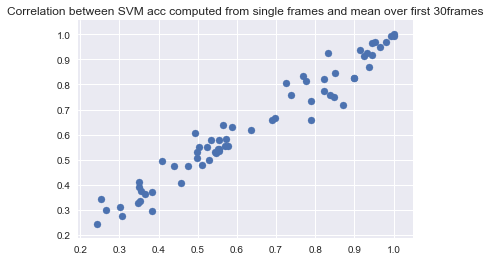

In [23]:
plt.title("Correlation between SVM acc computed from single frames and mean over first 30frames")
plt.scatter(df["svm_acc_mean"],df["svm_temp_acc_mean"])
# plt.xlabel("foo")
# plt.ylabel("foo")
sns.despine()

# Stimulus decoding accuracy

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1052182e8>]], dtype=object)

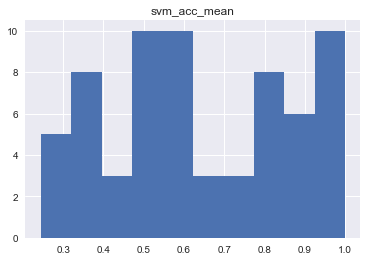

In [24]:
df.hist(column=["svm_acc_mean"])

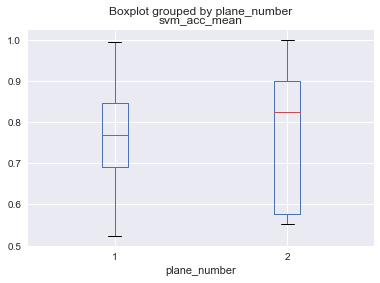

In [25]:
# Layer 2/3 comparison in stimulus decoding accuracy
sel = df.loc[(df["nb_stimuli"]==2) & (df["nb_stim_speed"]==1) & (df["plane1_layer"]==2) & (df["plane2_layer"]==3)]
sel.boxplot(column="svm_acc_mean", by="plane_number")

TypeError: boxplot() got an unexpected keyword argument 'group_by'

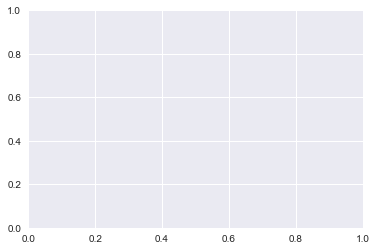

In [26]:
# Layer 2/3 comparison in stimulus decoding accuracy
sel = df.loc[(df["nb_stimuli"]==2) & (df["nb_stim_speed"]==1) & (df["plane1_layer"]==2) & (df["plane2_layer"]==3)]
sel.boxplot(column="svm_acc_mean", by="plane_number", group_by="indicator")

In [ ]:
# Similar plot but taking into account the individual data point errors and then plotting the aggregate SEM as error bar
means = []
stdvs = []
for plane in range(2):
    sel = df.loc[(df["nb_stimuli"]==2) & (df["plane1_layer"]==2) & (df["plane2_layer"]==3) & (df["plane_number"]==plane+1)]
    means.append(sel["svm_acc_mean"].mean())
    stdvs.append(np.sqrt(np.square(sel["svm_acc_stdev"]).mean()))
    
ind = list(range(1,3))
width = 0.7
ax = plt.subplot(1,1,1)
p1 = plt.bar(ind, means, width, yerr=stdvs/np.sqrt(len(stdvs)), color='gray')
ax.set_xlabel("Plane number")
ax.set_ylabel("Accuracy")
sns.despine()

# Running speed decoding

In [ ]:
# Layer 2/3 comparison in decoding accuracy of running speed
sel = df.loc[(df["nb_stimuli"]==2) & (df["nb_stim_speed"]==1) & (df["plane1_layer"]==2) & (df["plane2_layer"]==3)]
sel.boxplot(column="lasso_r2_mean", by="plane_number")
plt.ylim(0,1)

In [ ]:
# Similar plot but taking into account the individual data point errors and then plotting the aggregate SEM as error bar
means = []
stdvs = []
for plane in range(2):
    sel = df.loc[(df["nb_stimuli"]==2) & (df["plane1_layer"]==2) & (df["plane2_layer"]==3) & (df["plane_number"]==plane+1)]
    means.append(sel["lasso_r2_mean"].mean())
    stdvs.append(np.sqrt(np.square(sel["lasso_r2_stdev"]).mean()))
    
ind = list(range(1,3))
width = 0.7
ax = plt.subplot(1,1,1)
p1 = plt.bar(ind, means, width, yerr=stdvs/np.sqrt(len(stdvs)), color='gray')
ax.set_xlabel("Plane number")
ax.set_ylabel("Accuracy")
sns.despine()